# Import libraries

In [1]:
import gym
import math
import random
import numpy as np
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# from tensorflow.contrib.layers import fully_connected as dense
from tensorflow.compat.v1.layers import dense
from keras.models import Model, Sequential
from keras.layers import Input, Dense, BatchNormalization
from keras import backend as K
from keras.optimizers import Adam

import laser_hockey_env as lh
from importlib import reload

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


# Create environment

In [21]:
env = gym.make('CartPole-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('LunarLander-v2')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('CarRacing-v0')
# env = lh.LaserHockeyEnv()

In [3]:
# test = {[1,2]:0}
ord('w')

119

In [4]:
# from gym.utils import play


# key_mapping = {(97,108): 3, (100,108): 1, (108,119): 0, (108,115): 2}

# # Press L and W,A,S,D for movement

# def callback(obs_t, obs_tp1, action, rew, done, info):
#     return [rew,]
# plotter = play.PlayPlot(callback, 30 * 1, ["reward"])


# play.play(env, fps=30, callback=plotter.callback, keys_to_action=key_mapping)
# env.reset()
# env.close()

In [5]:
# import gym
# for i_episode in range(1000):
#     observation = env.reset()
#     for t in range(500):
# #         env.render()
#         action = env.action_space.sample()
#         observation, reward, done, info = env.step(action)
#         if done:
#             print("Episode finished after {} timesteps".format(t+1))
#             break
# env.close()

# Set up hyperparameters and settings

In [6]:
max_episodes = 2000
max_steps = 200

# Hyperparameters
actor_lr = 0.0003
critic_lr = 0.0003
actor_bs = 32
critic_bs = 32
gamma = 0.98
hidden_size = 100
epsilon = 0.2

# standardized or normalized returns for CartPole-v0
returns_mean = 37.965
returns_std = 12.579
returns_norm = 50

# Amount of discrete actions per dimension for Box space
k = 3

# Not used hyperparameters
lambda_ = 0.95

# Choose REINFORCE or PPO loss function, PPO uses epsilon
REINFORCE = True

# Choose to linearly anneal the learning rate from 1 to 0 over the course of learning
LINEAR = False

# Optimize every episode or every T timesteps, depending on environment
EPISODIC = True
if EPISODIC: T = max_steps
else: T = 128

# Represent the discrete distribution as factorized across dimensions
FACTORIZED = True

# Choose to imitate basic agent in LaserHockey and if only for the winning cases
IMITATION = True
WINNER = True
if env.unwrapped.spec is not None:
    IMITATION = False

# Set up Tensorboard
To launch tensorboard : `tensorboard --logdir "Google Drive/Reinforcement Learning/tensorboard/REINFORCE"`

`tensorboard --logdir "Google Drive/Reinforcement Learning/tensorboard/REINFORCE/LunarLander-v2"`

`tensorboard --logdir "tensorboard/REINFORCE"`


In [7]:
# Change parameters for different runs to have them seperate in Tensorboard
# writer = tf.summary.create_file_writer('/tensorboard/REINFORCE/CartPole-v0/'
#                                'E=' + str(max_steps) + ', T=' + str(T) +
#                                ', lr_a=' + str(actor_lr) + ', lr_c=' + str(critic_lr) +
#                                ', bs_a=' + str(actor_bs) + ', bs_c=' + str(critic_bs) +
#                                ', g=' + str(gamma) + ', hs=2x' + str(hidden_size) +
#                                ', e=0.2, vs basic 3x3')

writer = tf.summary.FileWriter('/Users/ghost/Google Drive/Reinforcement Learning/tensorboard/REINFORCE/CartPole-v0/'
                               'E=' + str(max_steps) + ', T=' + str(T) +
                               ', lr_a=' + str(actor_lr) + ', lr_c=' + str(critic_lr) +
                               ', bs_a=' + str(actor_bs) + ', bs_c=' + str(critic_bs) +
                               ', g=' + str(gamma) + ', hs=2x' + str(hidden_size) +
                               ', returns_norm')

# Show and compute specifications of environment

In [22]:
print('Actionspace')
print('=========================')
print(env.action_space)
if env.action_space.shape == ():
    print(env.action_space.n)
else:
    print(env.action_space.shape[0])
    print(env.action_space.high)
    print(env.action_space.low)
print('=========================')
print('Observationspace')
print('=========================')
print(env.observation_space)
print(env.observation_space.shape[0])
print(env.observation_space.high)
print(env.observation_space.low)

Actionspace
Box(1,)
1
[1.]
[-1.]
Observationspace
Box(2,)
2
[0.6  0.07]
[-1.2  -0.07]


In [9]:
# Compute dimensions for model's input/output sizes.
observation_dim = env.observation_space.shape[0]
    # Checking if Descrete or Box action space
if env.action_space.shape == ():
    a_dim, action_dim = 1, env.action_space.n
    policy_dim = a_dim
else:
    # If environment is LaserHockey take only the first 3 action dimensions.
    if env.unwrapped.spec is None: a_dim = 3
    else: a_dim = env.action_space.shape[0]
    if FACTORIZED: action_dim, policy_dim = k, a_dim
    else: action_dim, policy_dim = k**a_dim, 1
    
    # Also compute descrete actionspace for the Box space, because the Descrete space doesn't need one.
    actionspace = []
    for d in range(a_dim):
        actionspace.append(np.linspace(env.action_space.high[d], env.action_space.low[d], k))
    actionspace = np.array(np.meshgrid(*actionspace)).reshape(a_dim, -1).T
    actionspace_numbers = np.arange(k**a_dim)
    actionspace_numbers = actionspace_numbers.reshape(np.full(policy_dim, action_dim))
    
    print('Descretized actionspace and corresponding numbers')
    print('=================================================')
    print(actionspace)
    print(actionspace_numbers)

# Help functions

In [10]:
def descrete_action(action):
    for i in range(3):
        if action[i] > 0.5:
            action[i] = 1
        elif action[i] < -0.5:
            action[i] = -1
        else: action[i] = 0
    return action

def mean_list(lst):
    if len(lst) != 0:
        return sum(lst)/len(lst)
    return 0

def match_action_labels(action_labels):
    for i in range(len(action_labels[0])):
        for j in range(policy_dim):
            action_labels[j][i][0] = i
    return action_labels

def action_label_to_action(action_label):
    if env.action_space.shape == ():
        return action_label[0]
    return actionspace[actionspace_numbers.item(*action_label)]

def action_to_action_label(action):
    for i in range(k**a_dim):
        if np.array_equal(actionspace[i], action):
            return np.argwhere(actionspace_numbers == i).flatten()

def discount_rewards(episode_r, discount):
    value_f = 0
    discounted_rewards = np.zeros_like(episode_r, dtype='float64')
    for t in reversed(range(len(discounted_rewards))):
        value_f = value_f * discount + episode_r[t]
        discounted_rewards[t] = value_f
    return discounted_rewards

def td_error(episode_obs, episode_r):
    td_errors = np.zeros(len(episode_r) - 1)
    for t in range(len(td_errors)):
        if t == (len(td_errors) - 1):
            td_errors[t] = episode_r[t] + gamma * episode_r[-1] - critic.predict(episode_obs[t].reshape(1, -1))[0]
        else:
            td_errors[t] = episode_r[t] + gamma * critic.predict(episode_obs[t+1].reshape(1, -1))[0] - critic.predict(episode_obs[t].reshape(1, -1))[0]
    return td_errors

def subtract_baseline(episode_obs, value_f):
    advantages = np.zeros_like(value_f)
    for t in range(len(advantages)):
#         advantages[t] = 1.0
        advantages[t] = value_f[t] - critic.predict(episode_obs[t].reshape(1, -1))[0]
    return advantages

def clip_advantages(advantages):
    clipped_advantages = np.zeros_like(advantages)
    for i in range(len(clipped_advantages)):
        if advantages[i] >= 0:
            clipped_advantages[i] = (1 + epsilon) * advantages[i]
        else: clipped_advantages[i] = (1 - epsilon) * advantages[i]
    return clipped_advantages

In [11]:
# import torch
# x = torch.rand(5, 3)
# print(x)
# torch.cuda.is_available()

# Create Policy Gradient or PPO model

In [12]:
with tf.name_scope("inputs"):    
    # Placeholders for Tensorboard
    reward_ = tf.placeholder(tf.float32, name='reward')
#     actor_loss_ = tf.placeholder(tf.float32, name='actor_loss')
    critic_loss_ = tf.placeholder(tf.float32, name='critic_loss')
    
    # Placeholders for training
    input_ = tf.placeholder(tf.float32, [None, observation_dim], name='input')
    action_label_ = tf.placeholder(tf.int32, [None, None, 2], name='action_label')
    advantage_ = tf.placeholder(tf.float32, [None,], name='advantage')
    clipped_advantage_ = tf.placeholder(tf.float32, [None,], name='clipped_advantage')
    
    with tf.name_scope('policy'):
        relu_1, relu_2, action_distribution = {}, {}, {}
        for i in range(policy_dim):
            relu_1[i] = dense(inputs = input_, units = hidden_size, activation = tf.nn.relu,
                              kernel_initializer = tf.compat.v1.keras.initializers.glorot_normal())
            relu_2[i] = dense(inputs = relu_1[i], units = hidden_size, activation = tf.nn.relu,
                              kernel_initializer = tf.compat.v1.keras.initializers.glorot_normal())
            action_distribution[i] = dense(inputs = relu_2[i], units = action_dim, activation = tf.nn.softmax,
                                           kernel_initializer = tf.compat.v1.keras.initializers.glorot_normal())
            
#             relu_1[i] = dense(inputs = input_, num_outputs = hidden_size, activation_fn = tf.nn.relu,
#                               weights_initializer = tf.contrib.layers.xavier_initializer())
#             relu_2[i] = dense(inputs = relu_1[i], num_outputs = hidden_size, activation_fn = tf.nn.relu,
#                               weights_initializer = tf.contrib.layers.xavier_initializer())
#             action_distribution[i] = dense(inputs = relu_2[i], num_outputs = action_dim, activation_fn = tf.nn.softmax,
#                                            weights_initializer = tf.contrib.layers.xavier_initializer())
                
    with tf.name_scope('policy_loss'):
        joint_policy = tf.Variable(1.0)
        for i in range(policy_dim):
            joint_policy = joint_policy * tf.gather_nd(action_distribution[i], action_label_[i])
            
        if REINFORCE:
            # Policy gradient objective function
            policy_loss = tf.reduce_mean(tf.log(joint_policy + 1e-10) * advantage_)
        else:
            # PPO Clipped Surrogate Objective
            old_policy = tf.stop_gradient(tf.identity(joint_policy))
            policy_loss = tf.reduce_mean(tf.minimum(joint_policy / (old_policy + 1e-10) * advantage_, clipped_advantage_))
    
    with tf.name_scope('optimizers'):
        optimizer = tf.train.AdamOptimizer(actor_lr).minimize(-policy_loss)
        
    
tf.summary.scalar('Reward', reward_)
# tf.summary.scalar('Policy_Loss', actor_loss_)
tf.summary.scalar('Policy_Loss', policy_loss)
tf.summary.scalar('Critic_Loss', critic_loss_)

summary = tf.summary.merge_all()

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


# Model help functions

In [13]:
def actor_loss(old_prediction, advantage, clipped_advantage):
    def loss(y_true, y_pred):
#         new_prediction = tf.gather_nd(y_pred, tf.cast(y_true, tf.int64))
        new_prediction = y_true * y_pred
        if REINFORCE:
            return -K.mean(K.log(new_prediction + 1e-10) * advantage)
        r = new_prediction / (old_prediction + 1e-10)
        return -K.mean(K.minimum(r * advantage, clipped_advantage))
    return loss

class decay_history(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.lr.append(linear_decay(episode))
        print(' lr:', self.lr[-1])

def linear_decay(episode):
    decay = -(1 / max_episodes) * episode + 1
    new_lr = critic_lr * decay
    if LINEAR:
        print(new_lr)
        return new_lr
    print(critic_lr)
    return critic_lr

decay_history = decay_history()
new_lr = tf.keras.callbacks.LearningRateScheduler(linear_decay)
# callbacks_list = [decay_history, new_lr]
callbacks_list = [new_lr]

# Critic Network

In [14]:
critic = Sequential([
#     BatchNormalization(),
    Dense(hidden_size, kernel_initializer='glorot_normal', activation='relu'),
#     BatchNormalization(),
    Dense(hidden_size, kernel_initializer='glorot_normal', activation='relu'),
#     BatchNormalization(),
    Dense(1, kernel_initializer='glorot_normal')])

critic.compile(optimizer=Adam(lr=0.0), loss='mse', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# Actor Network

In [15]:
# Didn't worked yet

# def build_actor():
#     state_input = Input(shape=(observation_dim,))
#     old_prediction = Input(shape=(1,))
#     advantage = Input(shape=(1,))
#     clipped_advantage = Input(shape=(1,))

#     x = Dense(hidden_size, kernel_initializer='glorot_normal', activation='relu')(state_input)
#     x = Dense(hidden_size, kernel_initializer='glorot_normal', activation='relu')(x)
#     action_distribution = Dense(action_dim, kernel_initializer='glorot_normal', activation='softmax')(x)

#     model = Model(inputs=[state_input, old_prediction, advantage, clipped_advantage], outputs=[action_distribution])
#     model.summary()
#     model.compile(optimizer=Adam(lr=actor_lr), loss=[actor_loss(old_prediction, advantage, clipped_advantage)])

#     return model

# actor = build_actor()

# Train agent

In [ ]:
all_rewards, mean_steps = [], []
player1_won, player2_won, no_one_won = 0, 0, 0
basic = lh.BasicOpponent()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer.add_graph(sess.graph)
#     tf.train.Saver().restore(sess, "./models/model.ckpt")
    tf.train.Saver().save(sess, "./models/model.ckpt")
    
    for episode in range(1, max_episodes + 1):
        episode_rewards = []
        observations, observations_2, action_labels, action_labels_2 = [], [], [], []
        for i in range(policy_dim):
            action_labels.append([])
            action_labels_2.append([])
        
        observation = env.reset()
        if env.unwrapped.spec is None:
            obs_agent_2 = env.obs_agent_two()

        for step in range(1, max_steps + 1):
            
#             env.render()

            if not IMITATION:
                action_label = []
                for i in range(policy_dim):
                    action_vector = sess.run(action_distribution[i], feed_dict={input_: observation.reshape(1, -1)})[0]
                    action_label.append(np.random.choice(action_dim, p=action_vector))
                    # Compute action label for passing to the tf.gather_nd()
                    action_labels[i].append([0, action_label[i]])

                action = action_label_to_action(action_label)

                # Same process for second player in LaserHockey
                if env.unwrapped.spec is None:
#                     action_label = []
#                     for i in range(policy_dim):
#                         action_vector = sess.run(action_distribution[i], feed_dict={input_: obs_agent_2.reshape(1, -1)})[0]
#                         action_label.append(np.random.choice(action_dim, p=action_vector))
#                         action_labels_2[i].append([0, action_label[i]])

#                     action_2 = action_label_to_action(action_label)
#                     observations_2.append(obs_agent_2)
                    
                    action_2 = basic.act(obs_agent_2)
            
            else:
                observations_2.append(obs_agent_2)
                action = descrete_action(basic.act(observation))
                action_2 = descrete_action(basic.act(obs_agent_2))
                action_label = action_to_action_label(action)
                action_label_2 = action_to_action_label(action_2)
                for i in range(policy_dim):
                        action_labels[i].append([0, action_label[i]])
                        action_labels_2[i].append([0, action_label_2[i]])
                        
            observations.append(observation)
            
            if env.unwrapped.spec is None:
                observation, reward, done, info = env.step(np.hstack([action, action_2]))
                obs_agent_2 = env.obs_agent_two()
                
            else: observation, reward, done, info = env.step(action)
            
            episode_rewards.append(reward)
            
            
            
            # Optimization process
            if step % T == 0 or done or step == max_steps:
                T_new = step % T
                if T_new == 0: T_new = T
                
                if IMITATION: winner = info.get('winner')
                else: winner = 0
                
                
                if not (IMITATION and WINNER) or winner == 1:
                    # Calculate value and advantage functions with no lambda-return as alternative
                    returns = discount_rewards(episode_rewards[-T_new:], gamma)
#                     returns_std_each = (returns-np.mean(returns))/np.std(returns)
#                     returns_standardized = (returns-returns_mean)/returns_std
                    returns_normalized = returns/returns_norm
                    
#                     print(np.mean(returns))
#                     print(np.std(returns))
                    print(returns)
#                     print(returns_standardized)
                    print(returns_normalized)
                    
                    returns = returns_normalized
                    advantages = subtract_baseline(observations, returns)
                    clipped_advantages = clip_advantages(advantages)
    
                    print(advantages)
#                     print(observations)


                    # Calculate td-error and generalized advantage estimation
#                     TD_errors = td_error(observations[-step:], episode_rewards[-T_new:])
#                     GAE = discount_rewards(TD_errors, gamma * lambda_)
#                     prediction = sess.run(value, feed_dict={input_: observations[-1].reshape(1, -1)})
#                     GAE = np.append(GAE, episode_rewards[-1] - prediction)
#                     GAE = np.append(GAE, episode_rewards[-1] - critic.predict(observations[-1].reshape(1, -1))[0])

                    # Optimize
#                     actor_loss = actor.fit([observations, advantages, clipped_advantages], [action], batch_size=critic_bs)
                    critic_loss = critic.fit(np.array(observations), [returns], batch_size=critic_bs, callbacks=callbacks_list)

                    # Couldn't find a better way of implementing batch sizes in tensorflow
                    for i in range(math.ceil(T_new/actor_bs)):
                        temp_labels = []
                        for j in range(policy_dim):
                            temp_labels.append(action_labels[j][actor_bs*i:actor_bs*(i+1)])
                        temp_action_labels = match_action_labels(temp_labels)

                        sess.run(optimizer, feed_dict={input_: observations[actor_bs*i:actor_bs*(i+1)],
                                                       action_label_: temp_action_labels,
                                                       advantage_: advantages[actor_bs*i:actor_bs*(i+1)],
                                                       clipped_advantage_: clipped_advantages[actor_bs*i:actor_bs*(i+1)]})
                        
                
                # Same process for second player in LaserHockey
#                 if (not (IMITATION and WINNER) or winner == -1) and env.unwrapped.spec is None:
#                     returns = discount_rewards([-x for x in episode_rewards][-T_new:], gamma)
#                     advantages = subtract_baseline(observations_2, returns)
# #                     advantages = np.ones_like(returns)
#                     clipped_advantages = clip_advantages(advantages)

# #                     print(returns)
# #                     print(advantages)
# #                     print(len(observations_2))

#                     critic_loss = critic.fit(np.array(observations_2), [returns], batch_size=critic_bs, callbacks=callbacks_list)

#                     for i in range(math.ceil(T_new/actor_bs)):
#                         temp_labels = []
#                         for j in range(policy_dim):
#                             temp_labels.append(action_labels_2[j][actor_bs*i:actor_bs*(i+1)])
#                         temp_action_labels = match_action_labels(temp_labels)

#                         sess.run(optimizer, feed_dict={input_: observations_2[actor_bs*i:actor_bs*(i+1)],
#                                                        action_label_: temp_action_labels,
#                                                        advantage_: advantages[actor_bs*i:actor_bs*(i+1)],
#                                                        clipped_advantage_: clipped_advantages[actor_bs*i:actor_bs*(i+1)]})

            
            
            if step % T == 0 and not (done or step == max_steps):
                # Flush memory
                observations, observations_2, action_labels, action_labels_2 = [], [], [], []
                for i in range(policy_dim):
                    action_labels.append([])
                    action_labels_2.append([])
                    
            if done or step == max_steps:
                # Print rewards for solo environment or info for Laserhockey
                if env.unwrapped.spec is None:
                    mean_steps.append(step)
                    if info.get('winner') == 1: player1_won += 1
                    elif info.get('winner') == -1: player2_won += 1
                    else: no_one_won += 1; print('No one won.')
                
                all_rewards.append(np.sum(episode_rewards))    
                print("Timestep: ", step)
                print("Episode: ", episode)
                
                if env.unwrapped.spec is not None:
                    print("Reward: ", all_rewards[-1])
                    print("Max reward so far: ", np.max(all_rewards))
                
                
                # Add reward and losses to Tensorboard
                if not (IMITATION and WINNER) or winner != 0:
                    new_action_labels = match_action_labels(action_labels)
                    summary_ = sess.run(summary, feed_dict={input_: observations,
                                                            action_label_: new_action_labels,
                                                            advantage_: advantages,
                                                            clipped_advantage_: clipped_advantages,
                                                            reward_: all_rewards[-1],
#                                                             actor_loss_: actor_loss.history['loss'][-1],
                                                            critic_loss_: critic_loss.history['loss'][-1]})
                    writer.add_summary(summary_, episode)
                    writer.flush()
                    
                print("=====================================")
                
                break
        
        
        # Save Model every 50 episodes
        if episode % 50 == 0:
            tf.train.Saver().save(sess, "./models/model.ckpt")
            print("Model saved")
    tf.train.Saver().save(sess, "./models/model.ckpt")
    env.close()
    
    if env.unwrapped.spec is None:
        print('Player 1 won: ' + str(player1_won) + '/' + str(max_episodes))
        print('Player 2 won: ' + str(player2_won) + '/' + str(max_episodes))
        print('No one won: ' + str(no_one_won) + '/' + str(max_episodes))
        print('Mean steps: ' + str(mean_list(mean_steps)))
        print(mean_steps)

<function matplotlib.pyplot.show(*args, **kw)>

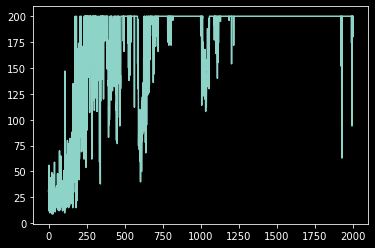

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')

plt.plot(all_rewards)
plt.show

# Show agent

In [20]:
human = lh.HumanOpponent(env=env, player=1)
basic = lh.BasicOpponent()
env.close()

Human Controls:
 left:			left arrow key left
 right:			arrow key right
 up:			arrow key up
 down:			arrow key down
 tilt clockwise:	d
 tilt anti-clockwise:	a


In [24]:
if env.unwrapped.spec is None:
    human = lh.HumanOpponent(env=env, player=1)
    basic = lh.BasicOpponent()

with tf.Session() as sess:
    rewards, mean_steps = [], []
    player1_won, player2_won, no_one_won = 0, 0, 0

#     Load the model
    tf.train.Saver().restore(sess, "./models/model.ckpt")

    max_test_episodes = 10
    max_test_steps = 200
    eps = 0
    
    for episode in range(1, max_test_episodes + 1):
        total_rewards = 0

        observation = env.reset()
        if env.unwrapped.spec is None: obs_agent_2 = env.obs_agent_two()
            
        for step in range(1, max_test_steps + 1):
            
            env.render()
            
            if random.random() < eps:
                action = random.choice(actionspace)
                action_2 = random.choice(actionspace)
            else:
                action_label = []
                for i in range(policy_dim):
                    action_vector = sess.run(action_distribution[i], feed_dict={input_: observation.reshape(1, -1)})[0]
                    action_label.append(np.random.choice(action_dim, p=action_vector))
#                 action = action_label_to_action(action_label)
#                 action = human.act(observation)

                # Same process for second player in LaserHockey
                if env.unwrapped.spec is None:
#                     action_label = []
#                     for i in range(policy_dim):
#                         action_vector = sess.run(action_distribution[i], feed_dict={input_: obs_agent_2.reshape(1, -1)})[0]
#                         action_label.append(np.random.choice(action_dim, p=action_vector))
#                     action_2 = action_label_to_action(action_label)
            
#                     action = basic.act(observation)
                    action_2 = basic.act(obs_agent_2)
#                     action = descrete_action(basic.act(observation))
#                     action_2 = descrete_action(basic.act(obs_agent_2))
            
            # np.hstack for LaserHockey environment
            if env.unwrapped.spec == None:
                
                observation, reward, done, info = env.step(np.hstack([action, action_2]))
                obs_agent_2 = env.obs_agent_two()
                
            else: observation, reward, done, info = env.step(action)

            total_rewards += reward
            
            if done or step == max_test_steps:
                # Print reward for solo environment or info for Laserhockey
                if env.unwrapped.spec is None:
                    mean_steps.append(step)
                    if info.get('winner') == 1: player1_won += 1
                    elif info.get('winner') == -1: player2_won += 1
                    else: no_one_won += 1; print('No one won.')
                
                print("Timestep: ", step)
                print("Episode: ", episode)
                
                if env.unwrapped.spec is not None:
                    rewards.append(total_rewards)
                    print("Reward: ", total_rewards)
                    
                print("========================================")
                    
                break
    env.close()
    
    if env.unwrapped.spec is None:
        print('Player 1 won: ' + str(player1_won) + '/' + str(max_test_episodes))
        print('Player 2 won: ' + str(player2_won) + '/' + str(max_test_episodes))
        print('No one won: ' + str(no_one_won) + '/' + str(max_test_episodes))
        print('Mean steps: ' + str(mean_list(mean_steps)))
        print(mean_steps)

INFO:tensorflow:Restoring parameters from ./models/model.ckpt
Timestep:  9
Episode:  1
Reward:  9.0
Timestep:  9
Episode:  2
Reward:  9.0
Timestep:  9
Episode:  3
Reward:  9.0
Timestep:  8
Episode:  4
Reward:  8.0
Timestep:  9
Episode:  5
Reward:  9.0
Timestep:  10
Episode:  6
Reward:  10.0
Timestep:  9
Episode:  7
Reward:  9.0
Timestep:  8
Episode:  8
Reward:  8.0
Timestep:  8
Episode:  9
Reward:  8.0
Timestep:  10
Episode:  10
Reward:  10.0


In [3]:
from gym.utils import play


key_mapping = {(97,108): 3, (100,108): 1, (108,119): 0, (108,115): 2}


def callback(obs_t, obs_tp1, action, rew, done, info):
    return [rew,]
plotter = play.PlayPlot(callback, 30 * 1, ["reward"])


env = gym.make('CarRacing-v0')
play.play(env, callback=None, keys_to_action=key_mapping)
env.reset()
env.close()

Track generation: 1203..1508 -> 305-tiles track


RuntimeError: generator raised StopIteration

In [4]:
import gym
env = gym.make('CarRacing-v0')
for i_episode in range(1):
    observation = env.reset()
    for t in range(200):
        env.render()
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

Track generation: 1040..1312 -> 272-tiles track


RuntimeError: generator raised StopIteration

In [24]:
# test = {[1,2]:0}
ord('w')

119